<a href="https://colab.research.google.com/github/lluisdn/TFM/blob/Additional/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Variation autoencoder**

#*Imports*


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
from keras import metrics

#*Data & preprocessing*

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
input_shape = (784, )
latent_dim = 2

#Encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)

# Mean and variance layer
z_mean = Dense(latent_dim, name='z_mean')(x)
z_var = Dense(latent_dim, name='z_var')(x)

#Sampling function
def sampling(z_mean, z_var):
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_var) * epsilon

# New sample
z = sampling(z_mean,z_var)
#z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean],[ z_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_inputs)
x = Dense(512, activation='relu')(x)
outputs = Dense(784, activation='sigmoid')(x)

# Encoder, decoder and VAE models
encoder = Model(inputs, [z_mean, z_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Lloss function
reconstruction_loss = metrics.binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
vae.compile(optimizer='adam')

#Summary of the encoder
encoder.summary()

print('--------------------------------------------------------------------------------------------')

print('--------------------------------------------------------------------------------------------')

print('--------------------------------------------------------------------------------------------')

#Summary of the decoder
decoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 512)          401920      ['encoder_input[0][0]']          
                                                                                                  
 dense_31 (Dense)               (None, 256)          131328      ['dense_30[0][0]']               
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['dense_31[0][0]']               
                                                                                            

#*Training*

In [ ]:
vae.fit(x_train, epochs=5, batch_size=128, validation_data=(x_test, None))

Epoch 1/5
469/469 [==============================] - 16s 31ms/step - loss: 185.8922 - val_loss: 166.2684
Epoch 2/5
469/469 [==============================] - 15s 31ms/step - loss: 161.5556 - val_loss: 157.9325
Epoch 3/5
469/469 [==============================] - 14s 30ms/step - loss: 155.9795 - val_loss: 154.1958
Epoch 4/5
469/469 [==============================] - 15s 33ms/step - loss: 152.9595 - val_loss: 151.8881
Epoch 5/5
469/469 [==============================] - 14s 30ms/step - loss: 150.9852 - val_loss: 150.4234


#*Predictions*

In [ ]:
predictions=vae.predict(x_test)

313/313 [==============================] - 1s 4ms/step


#*Plot*

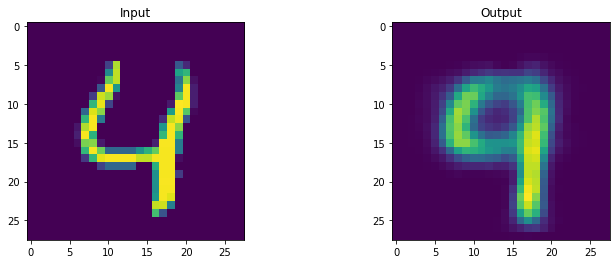

In [ ]:
#Plot of the initial and final pictures:
number=4
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(x_test[number].reshape(28, 28))
ax[0].set_title('Input')
ax[1].imshow(predictions[number].reshape(28, 28))
ax[1].set_title('Output')
plt.show()